In [332]:
#import all the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers

In [333]:
#read the data from your local machine
df = pd.read_csv("C:\\Users\\tejan\\Downloads\\practicedata\\diabetescsv\\diabetes.csv")

In [334]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


In [335]:
rus = RandomUnderSampler(random_state=123)
X_rus, y_rus = rus.fit_resample(df.drop('Outcome', axis = 1), df.Outcome)
print('Undersampled training dataset shape %s' % Counter(y_rus))
print('Original training dataset shape %s' % Counter(df.Outcome))


Undersampled training dataset shape Counter({0: 268, 1: 268})
Original training dataset shape Counter({0: 500, 1: 268})


In [336]:
df = pd.concat([X_rus, y_rus], axis = 1)

In [337]:
#the proportion of outcome classes is equal (50:50)
df.Outcome.value_counts()

1    268
0    268
Name: Outcome, dtype: int64

In [338]:
#create features and labels arrays from the data and standardize the features
X = df.drop('Outcome', axis = 1)
y = df.Outcome

#stadardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

# PCA

Create Principal components and merge the compnents with the target variable. I will first extract all 8 components and then decide how many components to use in the model.

In [339]:
#create PCA model and create the dataset containing extracted principal components and target variable
pca = PCA(random_state = 123).fit(data_scaled)
principalComponents = PCA(random_state = 123).fit_transform(data_scaled)

#create the principal components dataframe
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8'])

#merge this data with the target variable
finalDf_PCA = pd.concat([principalDf, df.Outcome], axis = 1)

In [340]:
finalDf_PCA.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,Outcome
0,0.58,-1.81,-0.83,0.08,-0.08,0.05,0.16,-0.39,0
1,1.83,-0.98,-0.31,0.18,0.67,-0.41,-0.48,0.39,0
2,1.75,2.46,-0.22,-0.23,0.89,-0.06,0.62,-0.54,0
3,0.30,-0.98,0.45,-1.42,-0.16,-1.09,-0.47,-0.11,0
4,-2.35,-2.34,1.46,-0.78,0.74,0.09,-0.10,-1.12,0


Plot the data against the principal components

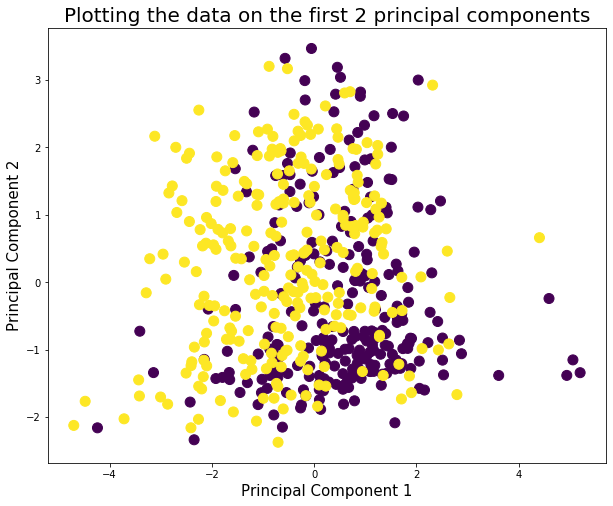

In [341]:
plt.figure(figsize = (10,8)) 
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title("Plotting the data on the first 2 principal components", fontsize = 20)
plt.scatter(finalDf_PCA.loc[:, 'pc1'], finalDf_PCA.loc[:, 'pc2'], c = finalDf_PCA.Outcome, s = 100)
plt.show()

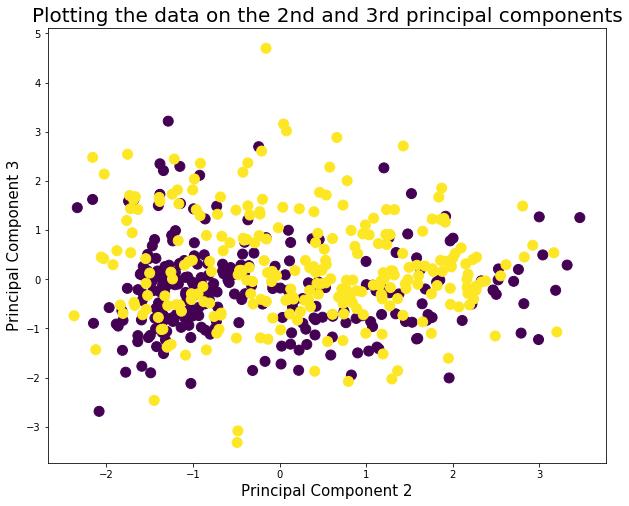

In [342]:
plt.figure(figsize = (10,8)) 
plt.xlabel('Principal Component 2', fontsize = 15)
plt.ylabel('Principal Component 3', fontsize = 15)
plt.title("Plotting the data on the 2nd and 3rd principal components", fontsize = 20)
plt.scatter(finalDf_PCA.loc[:, 'pc2'], finalDf_PCA.loc[:, 'pc3'], c = finalDf_PCA.Outcome, s = 100)
plt.show()

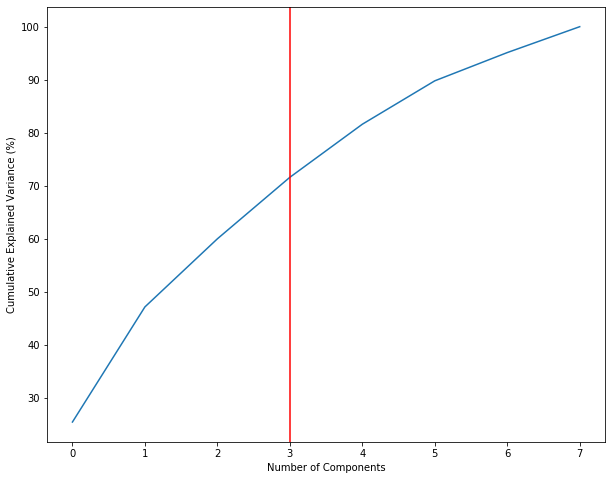

In [343]:
#plotting the cumulative variance plot
plt.figure(figsize = (10,8))
plt.plot(np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')

#plotting a red line on the 4th component
plt.axvline(x = 3, color = 'red')
plt.show()

I defined a function that outputs the reconstruction error and variance explained by a given number of components

In [344]:
def PCA_Variance_Explained(components):
    pca = PCA(n_components=components, random_state=123)
    
    #fit PCA for i components    
    pca_results = pca.fit_transform(data_scaled)

    #project the transformations back
    pca_proj_back = pca.inverse_transform(pca_results)

    #calculate the mean squared error 
    loss = ((data_scaled - pca_proj_back) ** 2).mean()
        
    #calculate the cumulative proportion of variance explained
    cum_var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

    print("The reconstruction error for {} components is {:.2f}".format(components, loss))
    print("The cumulative variance explained for {} components is {:.2f}%".format(components, cum_var[components-1]))

In [345]:
PCA_Variance_Explained(4)

The reconstruction error for 4 components is 0.28
The cumulative variance explained for 4 components is 71.61%


By selecting 4 components, we are retaining 71.61% of the variance in the data. It is my subjective decision to retain 4 components. Now, I will build logistic regression models on this principal components data to see how the components perform.

In [346]:
#creating the features data out of PCA data and using only the first 4 components
X = finalDf_PCA.drop('Outcome', axis = 1)
X = X.iloc[:, 0:4].values
y = np.ravel(finalDf_PCA.Outcome)

#random splitting of the data to training and validation data at 75:25 proportion
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

#building a logistic regression model
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

#calculating accuracy on training and validation data
score_test = logisticRegr.score(x_test, y_test)
score_train = logisticRegr.score(x_train, y_train)
print("The accuracy on training data is {:.2f}% and on validation data is {:.2f}%". format(score_train*100, score_test*100))


The accuracy on training data is 70.40% and on validation data is 64.93%


Seems like the above logistic regression model that uses 4 principal components as the features data is overfitting. This issue can be addresed by using regularizers. Since, this is not the main topic of this analysis, I will leave it here.

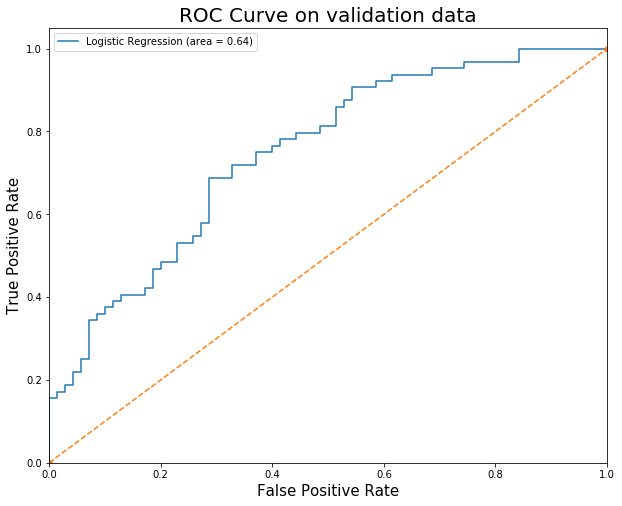

In [347]:
#plot the roc curve on the validation data
roc_auc = roc_auc_score(y_test, logisticRegr.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logisticRegr.predict_proba(x_test)[:,1])
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'p--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC Curve on validation data', fontsize = 20)
plt.legend(loc="upper left")
plt.show()

Now, I will build a model that uses all the features. This will be the example model for us to beat

In [348]:
#creating the features data out of PCA data and using all the components
X = finalDf_PCA.drop('Outcome', axis = 1).values
y = np.ravel(finalDf_PCA.Outcome)

#random splitting of the data to training and validation data at 75:25 proportion
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify = y)

#building a logistic regression model
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

#calculating accuracy on training and validation data
score_test = logisticRegr.score(x_test, y_test)
score_train = logisticRegr.score(x_train, y_train)
print("The accuracy on training data is {:.2f}% and on validation data is {:.2f}%". format(score_train*100, score_test*100))

The accuracy on training data is 75.37% and on validation data is 76.87%


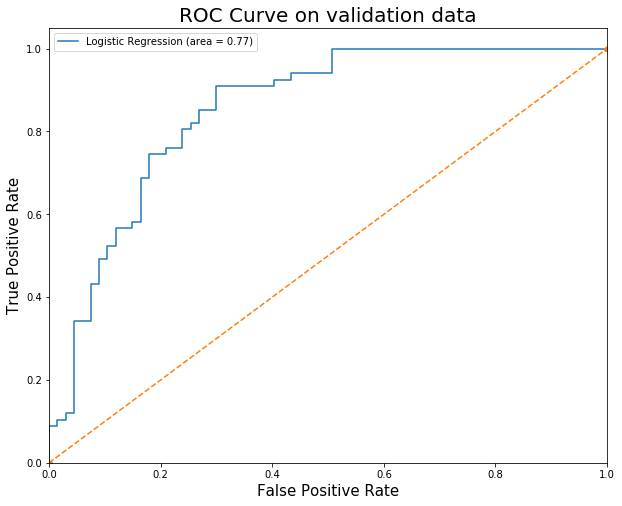

In [349]:
roc_auc = roc_auc_score(y_test, logisticRegr.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logisticRegr.predict_proba(x_test)[:,1])
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'p--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC Curve on validation data', fontsize = 20)
plt.legend(loc="upper left")
plt.show()

Now, I will build the autoencoders to extract 4 features out of 8. I will then use the 4 extracted features to build a logisctic regression model to compare it to PCA

In [350]:
input_dim = data_scaled.shape[1]  # 8
encoding_dim = 4 #Since we extracted 4 features from PCA

# Number of neurons in each Layer [8, 7, 5, 5, 4] of encoders
#build the encoder
input_layer = Input(shape=(input_dim, ))
encoder_layer_1 = Dense(7, activation="linear")(input_layer)
encoder_layer_2 = Dense(6, activation="linear")(encoder_layer_1)
encoder_layer_3 = Dense(5, activation="linear")(encoder_layer_2)
encoder_layer_4 = Dense(encoding_dim, activation="linear")(encoder_layer_3)


In [351]:
# Create encoder model
encoder = Model(inputs=input_layer, outputs=encoder_layer_4)

# Create the dataset and merge the data with target variable
encoded_data = pd.DataFrame(encoder.predict(data_scaled))
encoded_data.columns = ['factor_1', 'factor_2', 'factor_3', 'factor_4']

finalDf_AE = pd.concat([encoded_data, df.Outcome], axis = 1)

In [352]:
#extracting features out of the autoencoder data and converting them to arrays
X = finalDf_AE.drop('Outcome', axis = 1).values
y = np.ravel(finalDf_AE.Outcome)

#randomly splitting the data to training and validation data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [353]:
#build a logistic regression model
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

#calculating accuracy on training and validation data
score_test = logisticRegr.score(x_test, y_test)
score_train = logisticRegr.score(x_train, y_train)
print("The accuracy on training data is {:.2f}% and on validation data is {:.2f}%". format(score_train*100, score_test*100))

The accuracy on training data is 71.64% and on validation data is 68.66%


This model beat the logistic regression model that used principal components as features by 4.5% on validation accuracy. This is a huge margin.

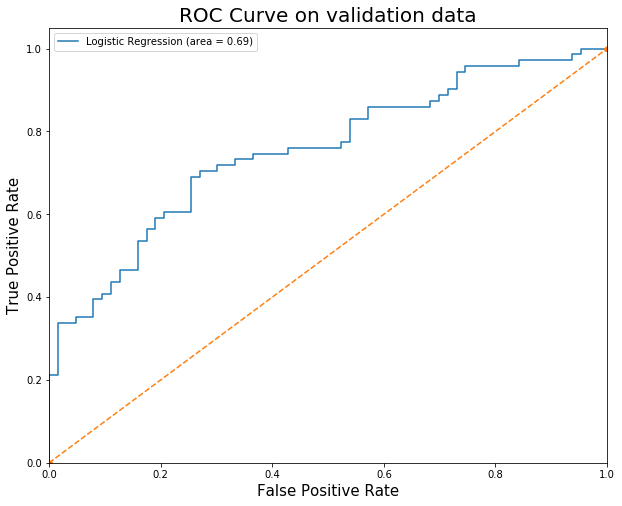

In [354]:
roc_auc = roc_auc_score(y_test, logisticRegr.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logisticRegr.predict_proba(x_test)[:,1])
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'p--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC Curve on validation data', fontsize = 20)
plt.legend(loc="upper left")
plt.show()

Plotting the data agains the extracted features from autoencoders

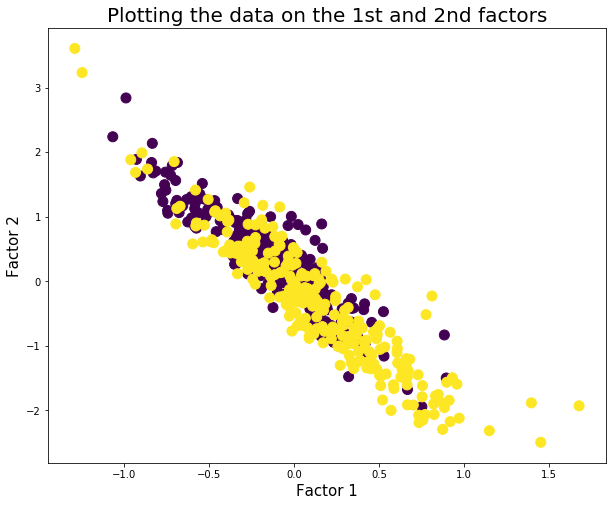

In [355]:
plt.figure(figsize = (10,8)) 
plt.xlabel('Factor 1', fontsize = 15)
plt.ylabel('Factor 2', fontsize = 15)
plt.title("Plotting the data on the 1st and 2nd factors", fontsize = 20)
plt.scatter(finalDf_AE.loc[:, 'factor_1'], finalDf_AE.loc[:, 'factor_2'], c = finalDf_AE.Outcome, s = 100)
plt.show()

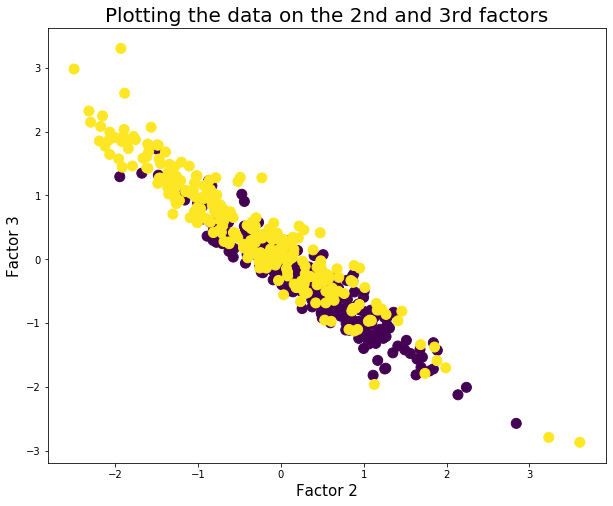

In [356]:
plt.figure(figsize = (10,8)) 
plt.xlabel('Factor 2', fontsize = 15)
plt.ylabel('Factor 3', fontsize = 15)
plt.title("Plotting the data on the 2nd and 3rd factors", fontsize = 20)
plt.scatter(finalDf_AE.loc[:, 'factor_2'], finalDf_AE.loc[:, 'factor_3'], c = finalDf_AE.Outcome, s = 100)
plt.show()

The autoencoders are finding patterns that are none like PCA in the multi-dimensional space. With different non-linear activation functions like sigmoid, relu, we can find different set of features and may get even more accuracy.